# Hospitality Market Demand Prediction
Yeounoh Chung and Tim Kraska, Brown University

## Introduction
Preparing and analyzing data is a challenge in many aspects, and yet, what is more important is to posing the right question. Often times, setting up an appropriate and meaningful hypothesis is what shapes the quality of your data analytics. In this post, we summarize the preliminary work done in collaboration with the analysts from TravelClick, and present the initial results. There are a number of interesting questions to be posed. For example, we have briefly looked at the casusality and the correlation between different market segments (e.g., luxury, economic, upscale, etc.), the significance of yearly occupancy differences of the same property, and the performance gap between a hotel and the market. But in the follow-up study, we have agreed to focus on predicting the hospitality market demands.

Hotels want to maximize profit. And to this end, they want to predict the demand-and-supply of the market. TravelClick brings about unique opportunity and values to its customers, the hotels, by providing aggregated (anonymized) information of their competitors in exchange for their own booking data. This aggregated information (a.k.a. Demand data) is already forward-looking, since it consists of bookings and reservations; however, the hotels can better plan and optimize their pricing if they can predict the market fluctuations beyond the collected bookings and their lead-time.

Here, we show that a traditional booking model with a simple trick can work very well and better than the baseline approach (advanced booking model).

## The Hospitality Market in Atlanta, GA.

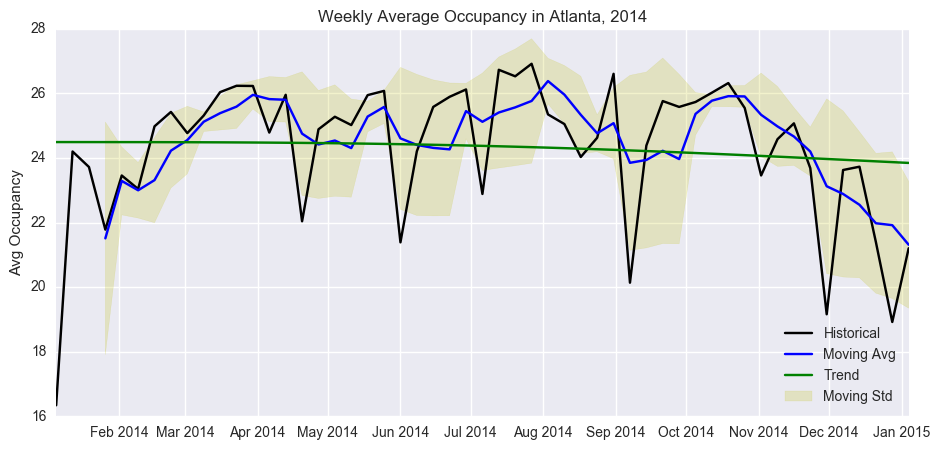

In [34]:
# We first look at the three (large, medium and small sizes) hotels in Atlanta, GA.
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt, mpld3
import statsmodels.api as sm
import seaborn as sb
sb.set_style('darkgrid')
import numpy as np
import pandas as pd
import pickle

# Load Weekly historical (occupancy) data from hotels in Atlanta, GA
atlData = pickle.load(open('atlData.p','rb'))

# rolling mean
ma = pd.rolling_mean(atlData, 4)
mstd = pd.rolling_std(atlData, 4)

# Hodrick-Prescott filter
cycle, trend = sm.tsa.filters.hpfilter(atlData,270400)

fig, ax = plt.subplots(1,1,figsize=(11,5),sharey=False)
ax.plot(atlData.index, atlData, 'k', label='Historical')
ax.plot(ma.index, ma, 'b', label='Moving Avg')
ax.fill_between(mstd.index, ma-mstd, ma+mstd, color='y', alpha=0.2, label='Moving Std')
ax.plot(trend.index, trend, 'g', label='Trend')
ax.set_ylabel('Avg Occupancy')
ax.legend(loc='lower right')
ax.set_title('Weekly Average Occupancy in Atlanta, 2014')

The above figure shows the weekly average occupancy in Atlanta for year 2014. The 'Historical' line is the original time-series data, and it has both cyclical and trend components. To examine the overall fluctuation of the market average occupancy, we show the 4-week 'Moving Avg' which smooths the noise (represented by 'Moving Std'). The average market occupancy (over all hotels in Atlanta, GA) went up sharply in January and dropped over the last month of the year; Hodrick-Prescott filtering yields a decreasing trend, which can be misleading as we would see a sharp increase in occupancy in the following months. Explicitly incorporating such seasonal biases is one of the next steps for tuning our forecasting models, but for now, we take an alternative approach: we transform the time-series data for building a predictive model (e.g., autoregression).

In practice, the time-series under scope is often non-stationary; on the other hand, Time-series regression or auto-correlation function requires stationary time-series data. Such transformation can be done simply by taking the first-order difference of the original time-series data: $y_t = x_t - x_(t-1)$.

To quickly test if the transformed time-series ($y_t$) is suitable for Auto-Regression model, we plot Autocorrelation Function (ACF) of $y_t$ and see if the function quickly tapers off to 0.

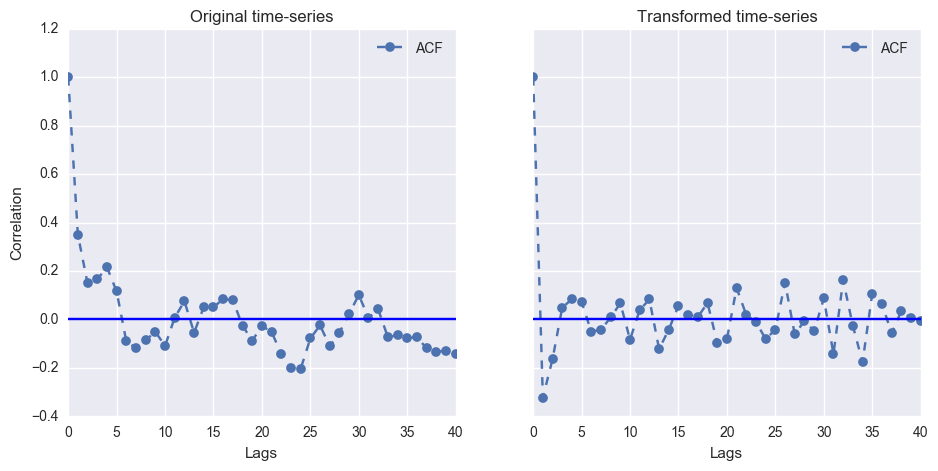

In [35]:
from statsmodels.tsa.stattools import acf

# Auto-Correlation Function
lag_corr = acf(atlData.iloc[1:]) # lag by 1

fig, ax = plt.subplots(1,2,figsize=(11,5),sharey=True)
ax[0].plot(lag_corr, marker='o', linestyle='--', label='ACF')
ax[0].axhline(y=0)
ax[0].set_title('Original time-series')
ax[0].set_xlabel('Lags')
ax[0].set_ylabel('Correlation')
ax[0].legend(loc='upper right')

atlDataDiff = atlData - atlData.shift()
lag_corr = acf(atlDataDiff.iloc[1:]) # lag by 1
ax[1].plot(lag_corr, marker='o', linestyle='--', label='ACF')
ax[1].axhline(y=0)
ax[1].set_title('Transformed time-series')
ax[1].set_xlabel('Lags')
ax[1].legend(loc='upper right')

ACF on the transformed time-series quickly drops to zero with a negligible variance ($\leq 0.2$). We now look at the first-order autoregression model, AR(1), of the transformed time-series: $y_t = \delta + \phi_1\cdot y_(t-1) + w_t$.

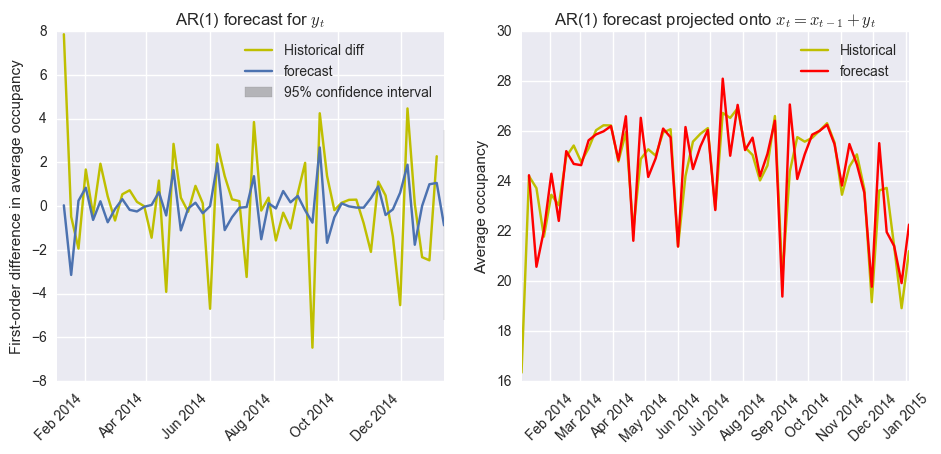

In [36]:
# ARIMA
model = sm.tsa.ARIMA(atlDataDiff.iloc[1:], order=(1,0,0)) # First-order autoregressive model
results = model.fit(disp=-1)
predict = results.predict()

fig, ax = plt.subplots(1,2,figsize=(11,5))
ax[0].plot(atlDataDiff.index, atlDataDiff,'y',label='Historical diff')
results.plot_predict(0,len(atlDataDiff)-1,dynamic=False,ax=ax[0],plot_insample=False)
ax[0].set_title('AR(1) forecast for $y_t$')
ax[0].set_ylabel('First-order difference in average occupancy')
labels = ax[0].get_xticklabels()
for label in labels:
    label.set_rotation(45)

ax[1].plot(atlData.index, atlData, 'y', label='Historical')
ax[1].plot(atlData.index, atlData + predict, 'r', label='forecast')
ax[1].set_title('AR(1) forecast projected onto $x_t=x_{t-1} + y_t$')
ax[1].set_ylabel('Average occupancy')
ax[1].legend(loc='upper right')
labels = ax[1].get_xticklabels()
for label in labels:
    label.set_rotation(45)

Even a simple predictive model works reasonably well for predicting the next week (notice how the forecast effectively models the sharp increase and decrease of the market demand at the year ends); however, forecasting several weeks and months ahead is much more difficult and AR(1) or any simple regressive models do not work -- i.e., the simple model here simply predict the next day given the history. We delve into the solution in the next section. Before we move on, we illustrate an interesting property of hospitality markets in general: major hotels in the town make up about 30% to 40% of the market, so they may lead the other non-major hotels in bookings.

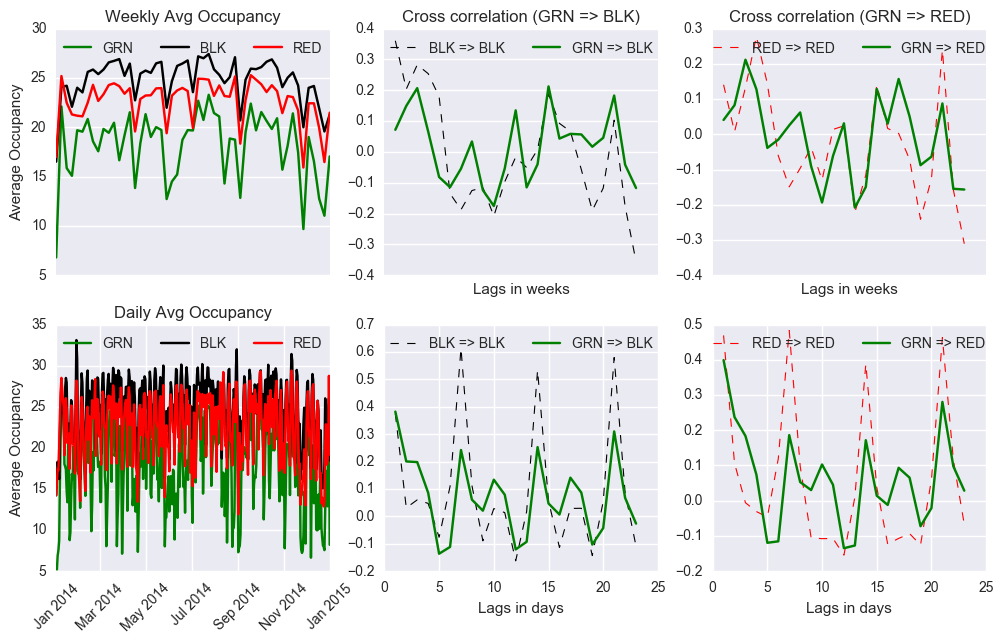

In [37]:
# Different market segments, labeled by market experts
green = pickle.load(open('atlDataGREEN.p','rb')) # major hotels
black = pickle.load(open('atlDataBLACK.p','rb')) # within the perimeter of GREEN
red = pickle.load(open('atlDataRED.p','rb')) # outside the perimeter of GREEN
greenD = pickle.load(open('atlDataGREENDay.p','rb')) # in days
blackD = pickle.load(open('atlDataBLACKDay.p','rb'))
redD = pickle.load(open('atlDataREDDay.p','rb')) 

# Cross-correlation
bb, rr, gb, gr = [], [], [], []
bbD, rrD, gbD, grD = [], [], [], []
lags = range(1,24)
for l in lags:
    bb.append(black.corr(black.shift(l)))
    rr.append(red.corr(red.shift(l)))
    gb.append(green.corr(black.shift(l)))
    gr.append(green.corr(red.shift(l)))
    bbD.append(blackD.corr(blackD.shift(l)))
    rrD.append(redD.corr(redD.shift(l)))
    gbD.append(greenD.corr(blackD.shift(l)))
    grD.append(greenD.corr(redD.shift(l)))
    
fig, ax = plt.subplots(2,3,figsize=(12,7))
ax[0][0].plot(green.index, green, 'g', label='GRN')
ax[0][0].plot(black.index, black, 'k', label='BLK')
ax[0][0].plot(red.index, red, 'r', label='RED')
ax[0][0].set_title('Weekly Avg Occupancy')
ax[0][0].legend(loc='upper center',ncol=3)
ax[0][0].set_ylabel('Average Occupancy')
ax[0][0].set_xticks([])

ax[0][1].plot(lags, bb, 'k--', linewidth=0.8, label='BLK => BLK')
ax[0][1].plot(lags, gb, 'g', label='GRN => BLK')
ax[0][1].set_title('Cross correlation (GRN => BLK)')
ax[0][1].legend(loc='upper center',ncol=3)
ax[0][1].set_xlabel('Lags in weeks')
ax[0][1].set_xticks([])

ax[0][2].plot(lags, rr, 'r--', linewidth=0.8, label='RED => RED')
ax[0][2].plot(lags, gr, 'g', label='GRN => RED')
ax[0][2].set_title('Cross correlation (GRN => RED)')
ax[0][2].legend(loc='upper center',ncol=3)
ax[0][2].set_xlabel('Lags in weeks')
ax[0][2].set_xticks([])

ax[1][0].plot(greenD.index, greenD, 'g', label='GRN')
ax[1][0].plot(blackD.index, blackD, 'k', label='BLK')
ax[1][0].plot(redD.index, redD, 'r', label='RED')
ax[1][0].set_title('Daily Avg Occupancy')
ax[1][0].legend(loc='upper center',ncol=3)
ax[1][0].set_ylabel('Average Occupancy')
labels = ax[1][0].get_xticklabels()
for label in labels:
    label.set_rotation(45)

ax[1][1].plot(lags, bbD, 'k--', linewidth=0.8, label='BLK => BLK')
ax[1][1].plot(lags, gbD, 'g', label='GRN => BLK')
ax[1][1].legend(loc='upper center',ncol=3)
ax[1][1].set_xlabel('Lags in days')

ax[1][2].plot(lags, rrD, 'r--', linewidth=0.8, label='RED => RED')
ax[1][2].plot(lags, grD, 'g', label='GRN => RED')
ax[1][2].legend(loc='upper center',ncol=3)
ax[1][2].set_xlabel('Lags in days')

In weekly data analysis, the major hotels (GREEN) does not appear to lead the others; the historical data of the other hotels (BLACK, RED) are better correlated with itself than with the major hotels. However, we find that GREEN is more strongly correlated with BLACK or RED up to 5 days time-difference. We originally exptected this to be useful in that we could adjust the initial predictions for non-major hotels by any abnormal behavior of the major hotels -- unfortunately, this is not so much so in learning a predictive model.

## Forecasting Market Demand

### Advanced Booking Model (baseline)
Market demands, particulary due to its dynamic market fluctuations and various complex enonomic factors, are hard to forecast. A very well tuned model for a certain year might fail the very next year for many reasons. The majority of research in time-series forecasting has focused on historical booking models, which directly model how the demand (e.g, Occupancy) changes over time; however, in our case, the historical booking models do not work -- or it requires a more complex modeling strategy, like we have shown in the previous section. An interesting alternative is to indirectly forecast the market by modeling the booking patterns (i.e., booking curves), how the accumulated number of reservation changes as the actual stay date approaches. 

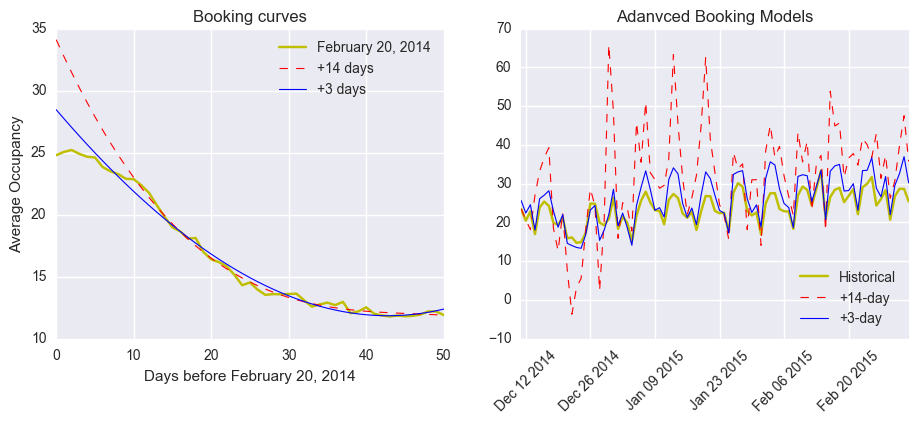

In [38]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

atlDataAdv = pickle.load(open('atlDataAdvO.p','rb')) # year 2014
atlDataAdv2 = pickle.load(open('atlDataAdvO2.p','rb')) # year 2015
dailyData = pd.concat([atlDataAdv, atlDataAdv2[1:]])

# Polynomial regression
reg = Pipeline([('poly', PolynomialFeatures(degree=3)),
                 ('linear', LinearRegression(fit_intercept=False))])
limit = 51
# 14-day ahead
X = [[i] for i in range(15,limit)]
y = list(dailyData.ix[50][[str(i) for i in range(15,limit)]])
reg14 = reg.fit(np.array(X), np.array(y)) # 14 days ahead
prediction14 = reg14.predict([[i] for i in range(limit)])

# 3-day ahead
X= [[i] for i in range(4,limit)]
y = list(dailyData.ix[50][[str(i) for i in range(4,limit)]])
reg3 = reg.fit(np.array(X),np.array(y)) # 14 days ahead
prediction3 = reg14.predict([[i] for i in range(limit)])

lead_time = [str(i) for i in range(limit)]
fig, ax = plt.subplots(1,2,figsize=(11,4),sharey=False)

ax[0].plot(range(limit), dailyData.ix[50][lead_time], 'y', label=dailyData.index[50].strftime("%B %d, %Y"))
ax[0].plot(range(limit), prediction14,'r--', linewidth=0.8, label='+14 days')
ax[0].plot(range(limit), prediction3,'b', linewidth=0.8, label='+3 days')
ax[0].set_title('Booking curves')
ax[0].set_ylabel('Average Occupancy')
ax[0].legend(loc='upper right', ncol=1)
ax[0].set_xlabel('Days before %s'%dailyData.index[50].strftime("%B %d, %Y"))


# Advanced Booking Model
prediction3 = []
for d in test_index:
    X = [[i] for i in range(4,limit)]
    y = list(dailyData.ix[d][[str(i) for i in range(4,limit)]])
    reg3 = reg.fit(np.array(X), np.array(y)) # 14 days ahead
    prediction3.append(reg3.predict([0]))
prediction3 = pd.Series(prediction3,index=test_index)
prediction14 = []
for d in test_index:
    X = [[i] for i in range(15,limit)]
    y = list(dailyData.ix[d][[str(i) for i in range(15,limit)]])
    reg14 = reg.fit(np.array(X), np.array(y)) # 14 days ahead
    prediction14.append(reg14.predict([0]))
prediction14 = pd.Series(prediction14,index=test_index)
ax[1].plot(test_index, dailyData.ix[test_index]['OCCUPANCY'], 'y', label='Historical')
ax[1].plot(test_index, prediction14, 'r--', linewidth=0.8, label='+14-day')
ax[1].plot(test_index, prediction3, 'b', linewidth=0.8, label='+3-day')
ax[1].set_title('Adanvced Booking Models')

ax[1].legend(loc='lower right', ncol=1)
labels = ax[1].get_xticklabels()
for label in labels:
    label.set_rotation(45)
    

As we can see in the figures above, when we can get a farily accurate booking curve for each target date (+3-day in advance predictin), we can forecast the market demand (i.e., average occupancy) faily well. However, Advanced booking model does not seem to work well at the market level, when we start to look ahead further into the future (+14-day in advance). Now, we show how we can do better with historical booking model, simply using the transformation trick from the previous section.

### Historicsal Booking Model
In the previous section, we have shown that by first transforming the original time-series data into a (weakly) stationary one, we can build a simple regressive model to forecast the market demand. 

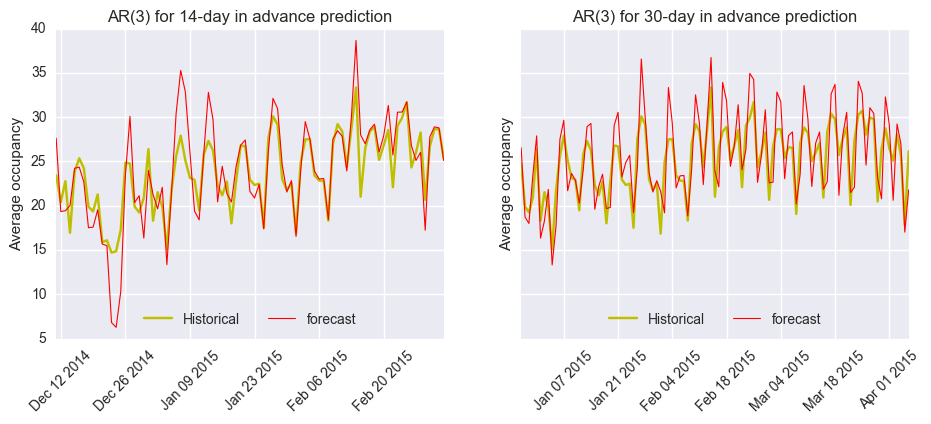

In [41]:
# Historical booking model
atlDataD = pickle.load(open('atlDataDay.p','rb')) # year 2014
atlDataD2 = pickle.load(open('atlDataDay2.p','rb')) # year 2015
dailyData = pd.concat([atlDataD, atlDataD2[1:]])


# Forecast two weeks ahead
atlDataDiff = dailyData - dailyData.shift(14) 
model = sm.tsa.ARIMA(atlDataDiff.iloc[14:], order=(3,0,0)) # autoregressive model
results = model.fit(disp=-1) # trained on 2014 data
predict = results.predict(330, 414, dynamic=False) # index correcsponds to dailyData[330+14:400+14+1]
test_index = predict.index
test_results = dailyData[330:428+1].reindex(predict.index)
test_results = test_results.add(predict,fill_value=0)

fig, ax = plt.subplots(1,2,figsize=(11,4), sharey=True)
ax[0].plot(test_results.index, dailyData[test_results.index], 'y', label='Historical')
ax[0].plot(test_results.index, test_results, 'r', linewidth=0.8, label='forecast')
ax[0].set_title('AR(3) for 14-day in advance prediction')
ax[0].set_ylabel('Average occupancy')
ax[0].legend(loc='lower center', ncol=2)
labels = ax[0].get_xticklabels()
for label in labels:
    label.set_rotation(45)

    
# Forecast one month ahead
atlDataDiff = dailyData - dailyData.shift(30) 
model = sm.tsa.ARIMA(atlDataDiff.iloc[30:], order=(3,0,0)) # autoregressive model
results = model.fit(disp=-1) # trained on 2014 data
predict = results.predict(330, 430, dynamic=False) # index correcsponds to dailyData[330+14:400+14+1]
test_results = dailyData[330:460+1].reindex(predict.index)
test_results = test_results.add(predict,fill_value=0)
    
ax[1].plot(test_results.index, dailyData[test_results.index], 'y', label='Historical')
ax[1].plot(test_results.index, test_results, 'r', linewidth=0.8, label='forecast')
ax[1].set_title('AR(3) for 30-day in advance prediction')
ax[1].set_ylabel('Average occupancy')
ax[1].legend(loc='lower center', ncol=2)
labels = ax[1].get_xticklabels()
for label in labels:
    label.set_rotation(45)


In this example, we have used a more complex autoregressive model with degree 3. We initially had misused the regressive model by predicting the next day based on the previous predictions; in this way, the error accumulates as we make predictions based on the previous predictions -- and the forecast quickly becomes useless. A better way to look at this is to make a prediction for a given day, based on the actual historical data you have (e.g., the past historical occupancy data from 14-day or more ago). In this general setting (e.g., Atlanta market in its entirety) this works better than the baseline (i.e., advanced booking model currently in use by TravelClick) and well enough to provide useful insight to the users.

# Conclusion
We have looked at the problem of forecasting the market demand using various time-series forecasting models. We have confirmed that a particular group of hotels could have higher correlation (i.e., leading the market) to the performance of the other hotel groups; however, this turned out to be insignificant to be useful in general. But, in forecasting market demand, we have shown that the traditional models with a simple trick (i.e., transforming the time-series data to a (weakly) stationary one for auto-regression) works very well and better than the baseline approach, currently being studied at TravelClick. Further study could potentially bring more improvement - and address other interesting hypotheses.